Version of **Python** and **Google Colab**

In [ ]:
!python --version
import google.colab
google.colab.__version__

Python 3.9.16


'0.0.1a2'

#Sentiment Analysis

##Building Model of Sentiment Analysis

### Here, we installed and imported some required libraries, and loading the dataset.

In [ ]:
import tweepy
import nltk
import re
import string
import pandas as pd
import numpy as np
import seaborn as sns
import joblib # to save model
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.image as mpimg
from wordcloud import WordCloud
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#plt.style.use('fivethirtyeight')

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ignored some warnings, which is less critical and not indicating problems in the code.

In [ ]:
# avoid deprecation warnings 
import warnings
warnings.filterwarnings('ignore')

Now, we are mounting Google Drive here, because we have our API credentials and dataset on Google Drive.

After it, we copied the 'Login.csv' file containing of API login credentials and dataset, which is in ZIP file. 

Then, unzipped the ZIP file to use it in our project.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp "/content/gdrive/MyDrive/Login.csv" "/content/Login.csv"
!cp "/content/gdrive/MyDrive/Twitter1.zip" "/content/Twitter1.zip"
!cp "/content/gdrive/MyDrive/emoji.zip" "/content/emoji.zip"
!cp "/content/gdrive/MyDrive/model.pkl" "/content/model.pkl"
!cp "/content/gdrive/MyDrive/archive.zip" "/content/archive.zip"
!unzip "/content/archive.zip" -d "/content/"
!unzip "/content/Twitter1.zip" -d "/content/"
!unzip "/content/emoji.zip" -d "/content/"

Loading the unzipped dataset into pandas dataframe. We used encoding here because some character was not understandable in UTF-8 format.

In [ ]:
# Loading the dataset into a pandas dataframe
load_df = pd.read_csv("twitter_training1.csv", encoding='ISO-8859-1')

### Preprocessing

We have some "Irrelevant" words in sentiment column of dataset, which is not useful for this project, so we removed all the rows containing 'Irrelevant' word.

In [ ]:
load_df = load_df[load_df['sentiment'] != 'Irrelevant']

The isnull() method returns a dataframe of the same shape as load_df filled with boolean values indicating if each element is missing or not. The sum() method calculates the sum of the boolean values for each column, giving us the count of missing values in each column.

In [ ]:
load_df.isnull().sum()

id             0
source         0
sentiment      0
text         571
dtype: int64

We have 61692 rows in 'sentiment' column and 61121 rows in 'text' column, so we had to remove the extra rows in sentiment column, for that we used the below code. It basically removes the column where the value of 'text' column is null.

In [ ]:
load_df = load_df[pd.notnull(load_df['text'])]

We have extra columns in the dataset and that is useless for this time, so we dropped them using below code.

In [ ]:
df= load_df.drop(['id', 'source'], axis=1)

There are many duplicate data/rows in the dataset, so we removed the duplicates here. Now, we can see previous entries was 61121 and after removing duplicates it is 51700 rows.

In [ ]:
df = df.drop_duplicates('text')

#### Cleaning texts.

After loading the dataset and removing unnecessary data, we have to clean, preprocess, do stemming and vectorize the text to get better and more accurate result.

Cleaning the text here. Removing mentions, '#' symbols, RTs and hyperlinks.

In [ ]:
def data_processing(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removed @mentions
  text = re.sub(r'#', '', text) #Removes the '#' symbol
  text = re.sub(r'RT[\s]+', '', text) #Removes RT
  text = re.sub(r'https?:\/\/S+', '', text) #Removes the hyperlink
  text = text.lower() # Convert text to lowercase
  text = re.sub(r'\d+', '', text) # Remove numbers
  text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
  text = text.strip() # Remove leading and trailing whitespaces
  tokens = nltk.word_tokenize(text) # Tokenize the text
  filtered_text = [w for w in tokens if not w in stop_words] # Remove stopwords
  return " ".join(filtered_text) # Join the filtered tokens

In [ ]:
# Preprocess the text data 
df['text'] = df['text'].apply(lambda x: data_processing(x))

Stemming is the process of reducing words to their base or root form. By reducing words to their base form, stemming can also help to improve the performance of sentiment analysis models.

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
  text = [stemmer.stem(word) for word in data]
  return data

In [ ]:
df['text'] = df['text'].apply(lambda x: stemming(x))

##### Charts of the sentiment and word cloud of dataset we used.

<Axes: xlabel='sentiment', ylabel='count'>

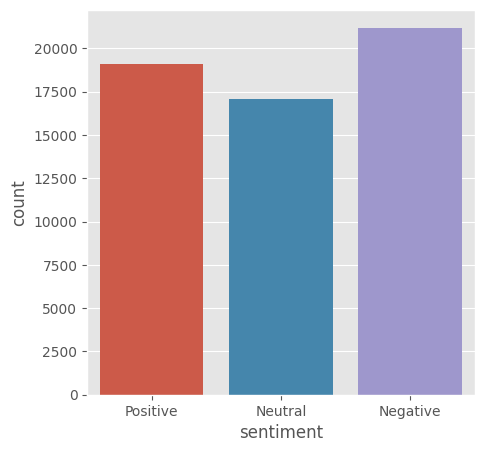

In [ ]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data= df)

Pie-chart

Text(0.5, 1.0, 'Distribution of Sentiments')

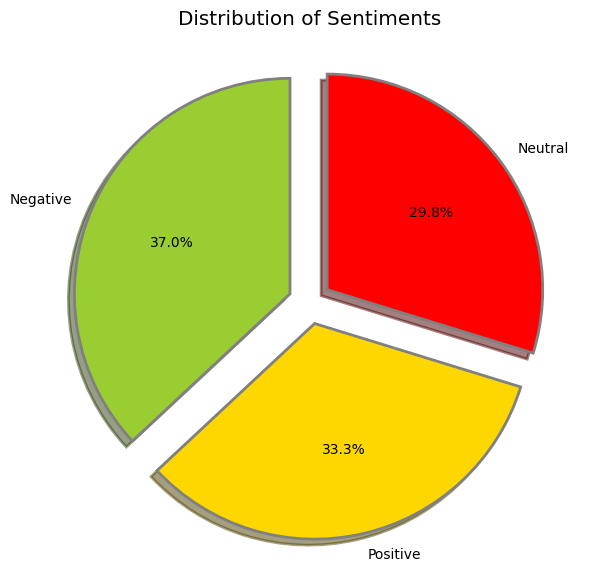

In [ ]:
fig = plt.figure(figsize=(7,7))
colors=("yellowgreen","gold","red")
wp={'linewidth':2, 'edgecolor':'grey'}
tags = df['sentiment'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie',autopct='%1.1f%%', shadow=True, colors = colors, startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of Sentiments')

######Positive Texts

In [ ]:
# positive
pos_tweets = df[df.sentiment == 'Positive']
#pos_tweets = pos_tweets.sort_values(['polarity'], ascending = False)
pos_tweets.head(20)

,sentiment,text
0,Positive,im getting borderlands murder
1,Positive,coming borders kill
2,Positive,im getting borderlands kill
3,Positive,im coming borderlands murder
4,Positive,im getting borderlands murder
5,Positive,im getting borderlands murder
6,Positive,spent hours making something fun dont know hug...
7,Positive,spent couple hours something fun dont know im ...
8,Positive,spent hours something fun dont know im huge bo...
9,Positive,spent hours making something fun dont know hug...


Word Cloud of Positive Texts

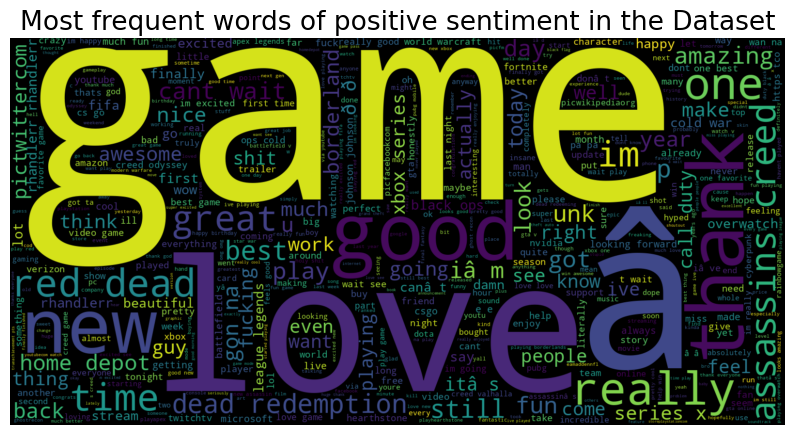

In [ ]:
# Word Cloud of Most frequent words in Positive Tweets
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(10,8), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words of positive sentiment in the Dataset', fontsize=19)
plt.show()

###### Negative Texts

In [ ]:
# negative
neg_tweets = df[df.sentiment == 'Negative']
neg_tweets.head()

,sentiment,text
24,Negative,biggest dissappoinment life came year ago fuck...
25,Negative,biggest disappointment life came year ago
27,Negative,biggest dissappoinment life coming year ago fu...
28,Negative,biggest male dissappoinment life came hanging ...
29,Negative,biggest dissappoinment life came back last yea...


Word Cloud of Negative Texts

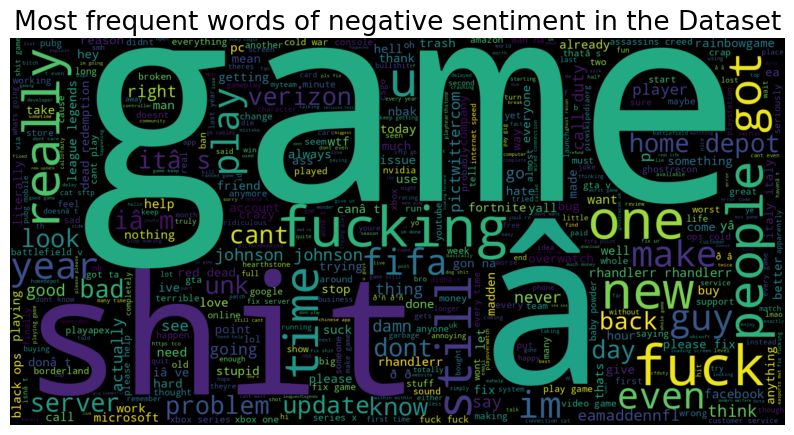

In [ ]:
# Word Cloud of Most frequent words in Negative Tweets
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(10,8), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words of negative sentiment in the Dataset', fontsize=19)
plt.show()

###### Neutral texts

In [ ]:
#neutral
neu_tweets = df[df.sentiment == 'Neutral']
neu_tweets.head()

,sentiment,text
12,Neutral,rockhard la varlope rare powerful handsome jac...
13,Neutral,rockhard la varlope rare powerful handsome jac...
14,Neutral,rockhard la varlope rare powerful handsome jac...
15,Neutral,rockhard la vita rare powerful handsome jackpo...
16,Neutral,live rock hard music la la varlope rare powerf...


Word Cloud

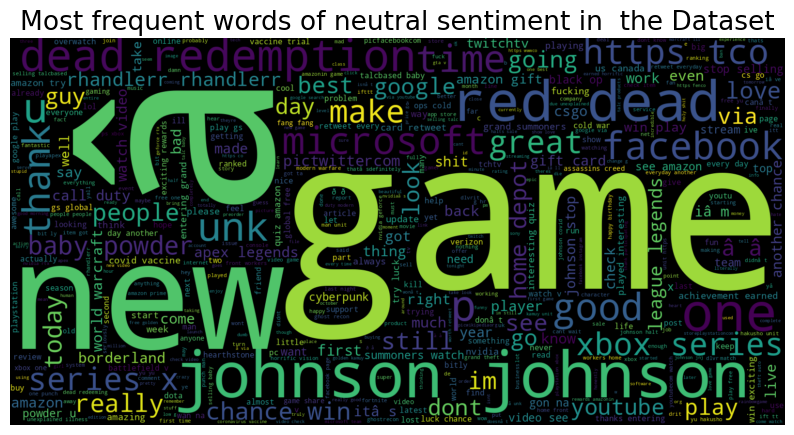

In [ ]:
# Word Cloud of Most frequent words in Neutral Tweet
text = ' '.join([word for word in neu_tweets['text']])
plt.figure(figsize=(10,8), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words of neutral sentiment in  the Dataset', fontsize=19)
plt.show()

##### Vectorization and getting features

We extracted features using CountVectorizer, it tokenize the text by breaking them into words.

ngram_range used so that the vectorizer should consider both unigrams(single words) and bigrams (pair of consecutive words) as tokens. We get features count of both single words and pairs of consecutive words.

In [ ]:
def vectorize(df):
    vect = CountVectorizer(ngram_range=(1, 2)).fit(df['text'])
    return vect

In [ ]:
vect = vectorize(df)

In [ ]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n {}".format(feature_names[:20]))

Number of features: 269216

First 20 features:
 ['aa' 'aa aa' 'aaa' 'aaa festel' 'aaa game' 'aaa gaming' 'aaa mike'
 'aaa pc' 'aaa rated' 'aaa record' 'aaa shooter' 'aaa tietel'
 'aaaaaaaaaaaa' 'aaaaaaaaaaaaa'
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
 'aaaaaaaaaaages' 'aaaaaaaaaaages worth' 'aaaaaaaaaages'
 'aaaaaaaaaages worth' 'aaarated']


Saving the vectorized form, features. It requires when analyzing other dataset using same model.

In [ ]:
joblib.dump(vect, 'vect.pkl')

['vect.pkl']

### Training and Testing

Now, we are at training part. For that, we have to split the dataset into training and testing.

We made two separate variables for 'text' and 'sentiment' column. 'text' to X and 'sentiment' to Y.

We apply CountVectorizer and using '.transform' get the matrix of token counts.

In [ ]:
X = df['text']
Y = df['sentiment']
X = vect.transform(X)

Splitting the dataset into 2 parts - two for training and rest for testing. We are splitting it into 80:20 ratio.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Printing count of entries and features.

In [ ]:
print("Size of x_train:", (x_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_train:", (y_train.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (45836, 269216)
Size of x_test: (11459, 269216)
Size of y_train: (45836,)
Size of y_test: (11459,)


#### Training and Testing using Algorithms - Saving the Best Model

#####LogisticRegression()

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)
lr_acc = accuracy_score(lr_pred, y_test)
print("Test accuracy: {:.2f}%".format(lr_acc*100))

Test accuracy: 91.87%


A confusion matrix is a table that is used to evaluate the performance of a binary classifier. Generated a classification report for the model using classification report.

In [ ]:
print(confusion_matrix(y_test, lr_pred))
print("\n")
print(classification_report(y_test, lr_pred))

[[3951   93  143]
 [ 204 3050  215]
 [ 177  100 3526]]


              precision    recall  f1-score   support

    Negative       0.91      0.94      0.93      4187
     Neutral       0.94      0.88      0.91      3469
    Positive       0.91      0.93      0.92      3803

    accuracy                           0.92     11459
   macro avg       0.92      0.92      0.92     11459
weighted avg       0.92      0.92      0.92     11459



We generated confusion matrix previously and now we are displaying it visually using ConfusionMatrixDisplay.

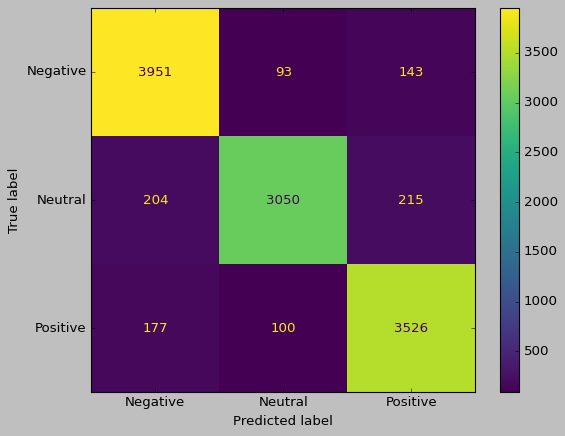

In [ ]:
plt.style.use('classic')
cm = confusion_matrix(y_test, lr_pred, labels = lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lr_model.classes_)
disp.plot()

##### LinearSVC

LinearSVC has more accuracy.

In [ ]:
lsvc_model = LinearSVC()
lsvc_model.fit(x_train, y_train)

LinearSVC()

In [ ]:
# Predicting and printing accuracy
lsvc_pred = lsvc_model.predict(x_test)
lsvc_acc = accuracy_score(lsvc_pred, y_test)
print("Test accuracy: {:.2f}%".format(lsvc_acc*100))

Test accuracy: 91.70%


In [ ]:
# Printing Confusion Mattrix
print(confusion_matrix(y_test, lsvc_pred))
print("\n")
print(classification_report(y_test, lsvc_pred))

[[3903  103  181]
 [ 175 3053  241]
 [ 159   92 3552]]


              precision    recall  f1-score   support

    Negative       0.92      0.93      0.93      4187
     Neutral       0.94      0.88      0.91      3469
    Positive       0.89      0.93      0.91      3803

    accuracy                           0.92     11459
   macro avg       0.92      0.92      0.92     11459
weighted avg       0.92      0.92      0.92     11459



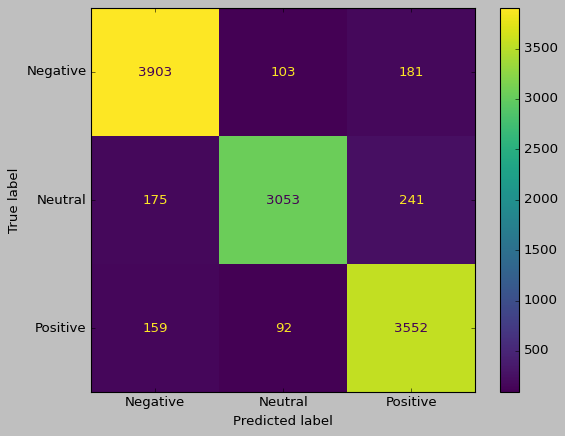

In [ ]:
plt.style.use('classic')
cm = confusion_matrix(y_test, lsvc_pred, labels = lsvc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=lsvc_model.classes_)
disp.plot()

##### KNN

K-Nearest Neighbors (KNN) is a machine learning algorithm commonly used for classification problems. In sentiment analysis, KNN can be used to predict the sentiment of a text by analyzing its features and comparing it to similar texts in the training set.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create KNN object
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the model using training data
knn_model.fit(x_train, y_train)

# Predict the classes of test data
knn_pred = knn_model.predict(x_test)

# Calculate the accuracy score
knn_acc = accuracy_score(y_test, knn_pred)

print(f"KNN Test Accuracy: {knn_acc*100:.4f}")

KNN Test Accuracy: 81.7523


In [ ]:
# Printing Confusion Mattrix
print(confusion_matrix(y_test, knn_pred))
print("\n")
print(classification_report(y_test, knn_pred))

[[3680  165  342]
 [ 579 2453  437]
 [ 396  172 3235]]


              precision    recall  f1-score   support

    Negative       0.79      0.88      0.83      4187
     Neutral       0.88      0.71      0.78      3469
    Positive       0.81      0.85      0.83      3803

    accuracy                           0.82     11459
   macro avg       0.83      0.81      0.81     11459
weighted avg       0.82      0.82      0.82     11459



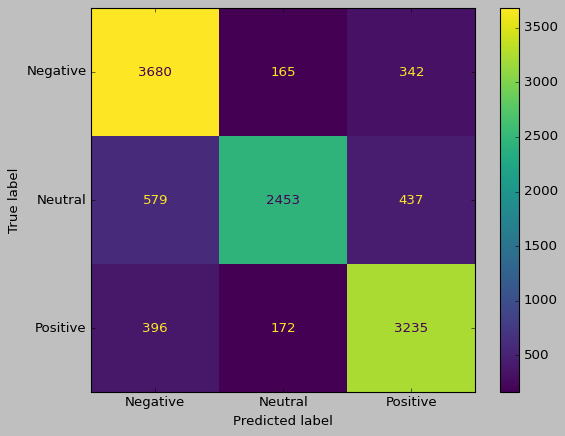

In [ ]:
plt.style.use('classic')
cm = confusion_matrix(y_test, knn_pred, labels = knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=knn_model.classes_)
disp.plot()

##### Naive Bayes

Naive Bayes is a simple probabilistic algorithm that assumes independence between the features. It's easy to implement and can work well with small datasets.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train a Naive Bayes Model on the training data
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)

# Predict the sentiment labels for the test data
nb_pred = nb_model.predict(x_test)

# Calculate the accuracy of the Naive Bayes Model on the test data
nb_acc = accuracy_score(y_test, nb_pred)

# Print the accuracy of the Naive Bayes Model
print("Naive Bayes Test accuracy: {:.2f}%".format(nb_acc*100))

Naive Bayes Test accuracy: 91.10%


In [ ]:
# Printing Confusion Mattrix
print(confusion_matrix(y_test, nb_pred))
print("\n")
print(classification_report(y_test, nb_pred))

[[3919   98  170]
 [ 196 2987  286]
 [ 173   97 3533]]


              precision    recall  f1-score   support

    Negative       0.91      0.94      0.92      4187
     Neutral       0.94      0.86      0.90      3469
    Positive       0.89      0.93      0.91      3803

    accuracy                           0.91     11459
   macro avg       0.91      0.91      0.91     11459
weighted avg       0.91      0.91      0.91     11459



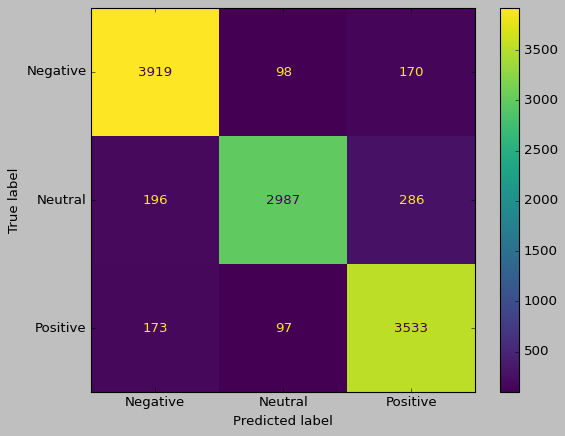

In [ ]:
plt.style.use('classic')
cm = confusion_matrix(y_test, nb_pred, labels = nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=nb_model.classes_)
disp.plot()

##### GridSearchCV()

Using gridsearchcv for finetuning every algorithm that we can get best results from them. and we shall compare it to get the best result that which algorithm performed best.

GridSearchCV used to get the best result from different parameters used to train and test the model.

(GridSearchCV does not actually train a model, it just finds the best hyperparameters for a given model and dataset.)

The GridSearchCV function performs a grid search by evaluating a model trained with different combinations of hyperparameters. The grid search is performed by training and evaluating the model multiple times with different hyperparameters and selecting the combination of hyperparameters that results in the best performance, as measured by a specific evaluation metric

In [ ]:
# Define the parameter grid for each model
lr_param_grid = {'C': [6, 7, 8], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
lsvc_param_grid = {'C': [0.08, 0.09, 0.1, 1]}
knn_param_grid = {'n_neighbors': [1, 3, 5],'metric': ['euclidean']}
nb_param_grid = {'alpha': [0.000025, 0.000026, 0.000027, 0.000028]}


# Define the parameter grids and models to search over
models = [
    {'model': lr_model, 'param_grid': lr_param_grid, 'name': 'Logistic Regression'},
    {'model': lsvc_model, 'param_grid': lsvc_param_grid, 'name': 'LinearSVC'},
    {'model': knn_model, 'param_grid': knn_param_grid, 'name': 'KNN'},
    {'model': nb_model, 'param_grid': nb_param_grid, 'name': 'Naïve Bayes'}
]

# Perform grid search over each model and print the best results
for model in models:
    print(f"Performing grid search for {model['name']}...")
    grid_search = GridSearchCV(model['model'], model['param_grid'], cv=5)
    grid_search.fit(x_train, y_train)
    print(f"Best parameters for {model['name']}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model['name']}: {grid_search.best_score_*100:.4f}%\n")
    model['best_params'] = grid_search.best_params_
 
# Train models with best parameters and evaluate on test data
for model in models:
    print(f"Evaluating {model['name']} with best parameters...")
    model['model'].set_params(**model['best_params'])
    model['model'].fit(x_train, y_train)
    model['ht_acc'] = "{:.4f}".format(model['model'].score(x_test, y_test)*100)
    print(f"Test accuracy for Hypertuned {model['name']}: {model['ht_acc']}\n")

Performing grid search for Logistic Regression...
Best parameters for Logistic Regression: {'C': 7, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 91.0878%

Performing grid search for LinearSVC...
Best parameters for LinearSVC: {'C': 0.1}
Best cross-validation score for LinearSVC: 91.1685%

Performing grid search for KNN...
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 1}
Best cross-validation score for KNN: 84.4467%

Performing grid search for Naïve Bayes...
Best parameters for Naïve Bayes: {'alpha': 2.6e-05}
Best cross-validation score for Naïve Bayes: 93.4615%

Evaluating Logistic Regression with best parameters...
Test accuracy for Hypertuned Logistic Regression: 92.5735

Evaluating LinearSVC with best parameters...
Test accuracy for Hypertuned LinearSVC: 92.6695

Evaluating KNN with best parameters...
Test accuracy for Hypertuned KNN: 86.9709

Evaluating Naïve Bayes with best parameters...
Test accuracy for Hypertuned

In [ ]:
models[0]['acc'] = lr_acc*100
models[1]['acc'] = lsvc_acc*100
models[2]['acc'] = knn_acc*100
models[3]['acc'] = nb_acc*100

In [ ]:
for model in models:
    print(model)
    print()

{'model': LogisticRegression(C=7, solver='liblinear'), 'param_grid': {'C': [6, 7, 8], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}, 'name': 'Logistic Regression', 'best_params': {'C': 7, 'penalty': 'l2', 'solver': 'liblinear'}, 'ht_acc': '92.5735', 'acc': 91.86665503098001}

{'model': LinearSVC(C=0.1), 'param_grid': {'C': [0.08, 0.09, 0.1, 1]}, 'name': 'LinearSVC', 'best_params': {'C': 0.1}, 'ht_acc': '92.6695', 'acc': 91.70084649620385}

{'model': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'param_grid': {'n_neighbors': [1, 3, 5], 'metric': ['euclidean']}, 'name': 'KNN', 'best_params': {'metric': 'euclidean', 'n_neighbors': 1}, 'ht_acc': '86.9709', 'acc': 81.75233440963436}

{'model': MultinomialNB(alpha=2.6e-05), 'param_grid': {'alpha': [2.5e-05, 2.6e-05, 2.7e-05, 2.8e-05]}, 'name': 'Naïve Bayes', 'best_params': {'alpha': 2.6e-05}, 'ht_acc': '94.3974', 'acc': 91.09869971201675}



##### Comparisions

Comparing models by their accuracy

In [ ]:
sorted_models = sorted(models, key=lambda x: x['ht_acc'], reverse=True)
for model in sorted_models:
    print(f"{model['name']} - Model Accuracy: {model['acc']:.4f}, Hypertuned Model Accuracy: {model['ht_acc']}")
    print()


Naïve Bayes - Model Accuracy: 91.0987, Hypertuned Model Accuracy: 94.3974

LinearSVC - Model Accuracy: 91.7008, Hypertuned Model Accuracy: 92.6695

Logistic Regression - Model Accuracy: 91.8667, Hypertuned Model Accuracy: 92.5735

KNN - Model Accuracy: 81.7523, Hypertuned Model Accuracy: 86.9709



We found ***Hypertuned Naïve Bayes*** model as best. Let's see its Confusion Matrix, Precision, F1 Score, Recall.

In [ ]:
nb_model_grid = models[3]['model']
nb_pred_grid = nb_model_grid.predict(x_test)

# Printing Confusion Mattrix
print(confusion_matrix(y_test, nb_pred_grid))
print("\n")
print(classification_report(y_test, nb_pred_grid))

[[3984   71  132]
 [  97 3222  150]
 [ 118   74 3611]]


              precision    recall  f1-score   support

    Negative       0.95      0.95      0.95      4187
     Neutral       0.96      0.93      0.94      3469
    Positive       0.93      0.95      0.94      3803

    accuracy                           0.94     11459
   macro avg       0.94      0.94      0.94     11459
weighted avg       0.94      0.94      0.94     11459



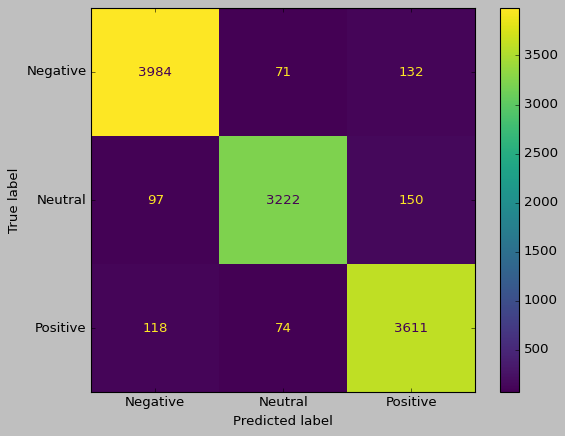

In [ ]:
plt.style.use('classic')
cm = confusion_matrix(y_test, nb_pred_grid, labels = nb_model_grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=nb_model_grid.classes_)
disp.plot()

#####Saving the model

In [ ]:
# save the model
joblib.dump(nb_model_grid, 'model.pkl')

['model.pkl']

Now the best resultant parameter saved to the model, we found it comparing using GridSearchCV. 

It fits the model with best algorithm by comparing used algorithms.

#### Code to display sentiment as emoji.

In [ ]:
happy = mpimg.imread('happy.png')
neut = mpimg.imread('neutral.png')
anger = mpimg.imread('angry.png')
def show_emoji(x):
  if x == 'Positive':
    imgplot = plt.imshow(happy)
    plt.axis('off')
    plt.title("Positive")
    plt.show()
  elif x == 'Neutral':
    imgplot = plt.imshow(neut)
    plt.axis('off')
    plt.title("Neutral")
    plt.show()
  else:
    imgplot = plt.imshow(anger)
    plt.axis('off')
    plt.title("Negative")
    plt.show()

## Twitter Fetch

Verifying login credential for Twitter API, and fetching the keyword from Twitter to analyze its sentiment.

### Login credential is stored in csv file so we are reading it here using pandas and storing it.

In [ ]:
# Get the Login credentials
log = pd.read_csv('Login.csv')

Now, the login data will be stored in required variable, so that we can use it to authenticate and login into API.

In [ ]:
# Twitter API credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

Authentication process

In [ ]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)

# Create the API object while passing in the auth information
api = tweepy.API(authenticate)

In [ ]:
me = api.verify_credentials()
print(me.screen_name)

sarojraja2398


###Enter Keyword and see the result

In [ ]:
#@title Getting input the 'keyword' that have to be fetched from Twitter to analyze.
k_word=input("Enter Keyword to search tweets for sentiment analysis: ")
# Extract 100 tweets from the twitter user

#tweets = api.search(q=k_word, lang='en', count=200, tweet_mode='extended')
"""for tweet in tweets:
  try:
    print(tweet.retweeted_status.full_text)
    print("=======")
  except AttributeError:
    print(tweet.full_text)
    print("=========")"""
extracted_tweets=[]
for tweet in tweepy.Cursor(api.search_tweets,k_word,lang='en', tweet_mode='extended').items(1000):
  if 'retweeted_status' in tweet._json:
    extracted_tweets.append(tweet._json['retweeted_status']['full_text'])
  else:
    extracted_tweets.append(tweet.full_text)
#Storing the fetched tweets into the dataframe called df1.
df1 = pd.DataFrame({'text': extracted_tweets})
print(df1.head())
print(len(df1))

Enter Keyword to search tweets for sentiment analysis: Adani
                                                text
0  Weekly breakout stocks to keep in radar \n\n⚡️...
1  Assam CM Himanta Biswa Sarma says he will file...
2  Who owns the Rs 20,000 crore invested in Adani...
3  Say My Friends are thief : #Modani\n#LalitModi...
4  Assam CM Himanta Biswa Sarma says he will file...
1000


In [ ]:
df1

,text
0,Weekly breakout stocks to keep in radar \n\n⚡️...
1,Assam CM Himanta Biswa Sarma says he will file...
2,"Who owns the Rs 20,000 crore invested in Adani..."
3,Say My Friends are thief : #Modani\n#LalitModi...
4,Assam CM Himanta Biswa Sarma says he will file...
...,...
995,My way of getting successful in life is just l...
996,@Jairam_Ramesh congratulations sir on your bir...
997,"Brand custodian of the Group, is himself being..."
998,Hmm… Adani is targeted. Mother of democracy. E...


Dropping if any duplicates, processing, stemming and vectorization to give it to model.

In [ ]:
df1 = df1.drop_duplicates('text')

df1['text'] = df1['text'].apply(lambda x: data_processing(x))
df1['text'] = df1['text'].apply(lambda x: stemming(x))

'.transform' transforms the tweets into numerical representations

Got the predicted sentiments from model.

Added the predictions as a new column 'sentiment' for later use to show results.

In [ ]:
# Transform the tweets into numerical representations
tweet_vectors = vect.transform(df1['text'].values)

# load the saved model
myModel = joblib.load('model.pkl')

# Feed the numerical representations into the trained model to make predictions
predictions = myModel.predict(tweet_vectors)

# Add the predictions as a new column in the DataFrame
df1['sentiment'] = predictions

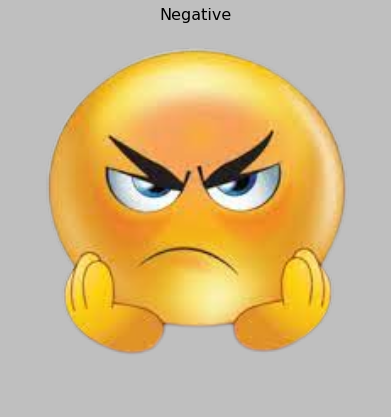

In [ ]:
# It gets the maximum sentiment.
sent = df1['sentiment'].value_counts().idxmax()
# Display sentiment as emoji
show_emoji(sent)

#### Pie-Chart and Bar-Chart of analyzed tweets 

Text(0.5, 1.0, 'Distribution of Sentiments of Adani')

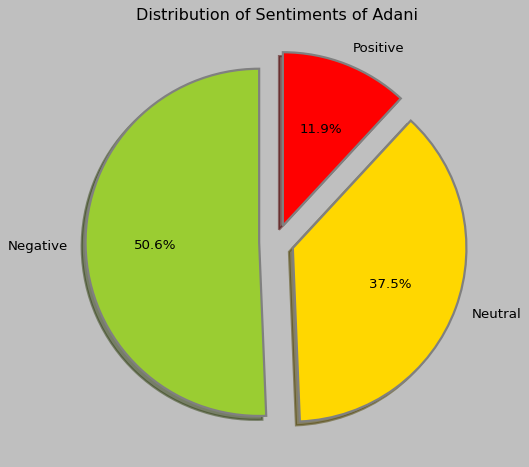

In [ ]:
fig = plt.figure(figsize=(7,7))
colors=("yellowgreen","gold","red")
wp={'linewidth':2, 'edgecolor':'grey'}
tags = df1['sentiment'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie',autopct='%1.1f%%', shadow=True, colors = colors, startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of Sentiments of {}'.format(k_word))

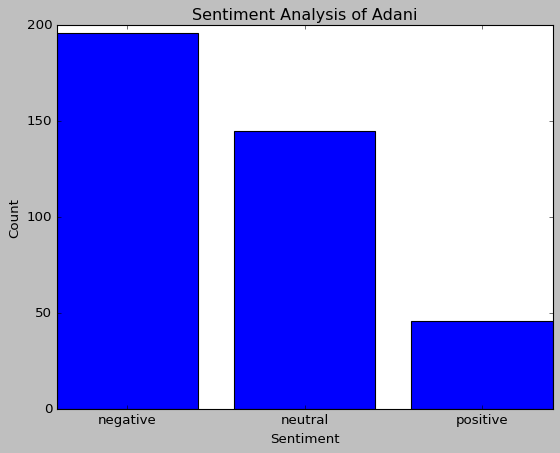

In [ ]:
sentiment_counts = np.unique(predictions, return_counts=True)[1]
sentiment_labels = ['negative', 'neutral', 'positive']

plt.bar(sentiment_labels, sentiment_counts)
plt.title('Sentiment Analysis of {}'.format(k_word))
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


Printing the Positive and Negative tweets separately.

In [ ]:
mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}

df1['predicted_sentiment'] = df1['sentiment'].map(mapping)
df1['predicted_sentiment'] = df1['predicted_sentiment'].astype(float)

# show the most positive tweets

print(df1.nlargest(5, 'predicted_sentiment'))

# show the most negative tweets
print(df1.nsmallest(5, 'predicted_sentiment'))

                                                 text sentiment  \
5               make adani great 🤭 httpstcorqentgzixm  Positive   
12  adaniscam adani ke company mein voh bees hazaa...  Positive   
16  high court roster got changed change respect a...  Positive   
30  well already focused adani last months lolday ...  Positive   
38  everything except khaleja face mediautter word...  Positive   

    predicted_sentiment  
5                   1.0  
12                  1.0  
16                  1.0  
30                  1.0  
38                  1.0  
                                                 text sentiment  \
1   assam cm himanta biswa sarma says file defamat...  Negative   
6   day month hindenberg report villege level one ...  Negative   
7   main issue adani main issue remain adani defle...  Negative   
11  frankly sharad pawar heads ncp inc games play ...  Negative   
13  congress unfazed sharad pawar ’ letdown adani ...  Negative   

    predicted_sentiment  
1           

#### Displaying Word Cloud of Positive, Neutral and Negative sentiments.


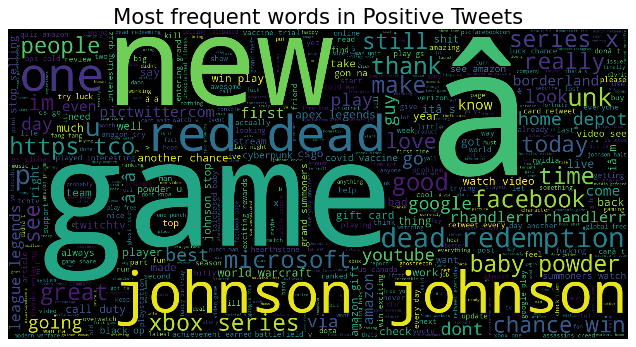

In [ ]:
# Word Cloud of Most frequent words in Positive Tweet
positive_text = ' '.join([word for word in df1[df1['sentiment'] == 'Positive']['text']])
plt.figure(figsize=(10,8), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Positive Tweets', fontsize=19)
plt.show()

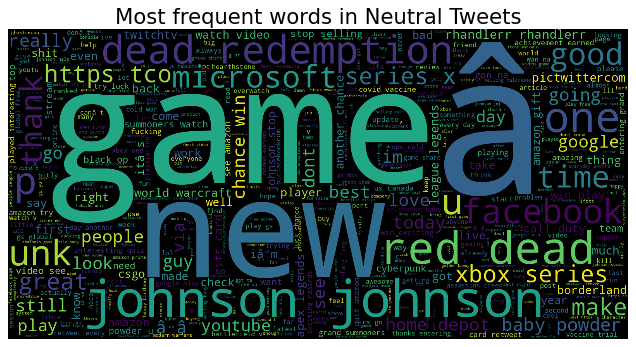

In [ ]:
# Word Cloud of Most frequent words in Neutral Tweet
positive_text = ' '.join([word for word in df1[df1['sentiment'] == 'Neutral']['text']])
plt.figure(figsize=(10,8), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Neutral Tweets', fontsize=19)
plt.show()

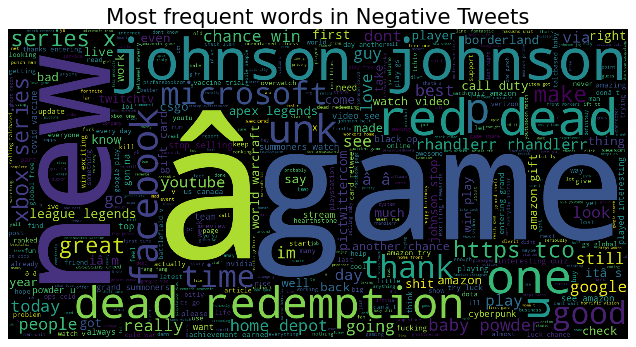

In [ ]:
# Word Cloud of Most frequent words in Negative Tweet
positive_text = ' '.join([word for word in df1[df1['sentiment'] == 'Negative']['text']])
plt.figure(figsize=(10,8), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in Negative Tweets', fontsize=19)
plt.show()

## Sentiment Analysis of entered text input

In [ ]:
# Code to take input by user and show its sentiment
texts1 = input("Enter Your Text to Check its Sentiment: ")
df4 = pd.DataFrame({'text': [texts1]})
df4['text'] = df4['text'].apply(lambda x: data_processing(x))
df4['text'] = df4['text'].apply(lambda x: stemming(x))

NameError: ignored

In [ ]:
# load the saved model
myModel = joblib.load('model.pkl')

# Transform the tweets into numerical representations
text_vectors = vect.transform(df4['text'].values)

# Feed the numerical representations into the trained model to make predictions
predictions1 = myModel.predict(text_vectors)

# Add the predictions as a new column in the DataFrame
print(predictions1)

['Negative']


In [ ]:
from collections import Counter
# Find the most common sentiment
counter = Counter(predictions1)
most_sent = counter.most_common(1)[0][0]

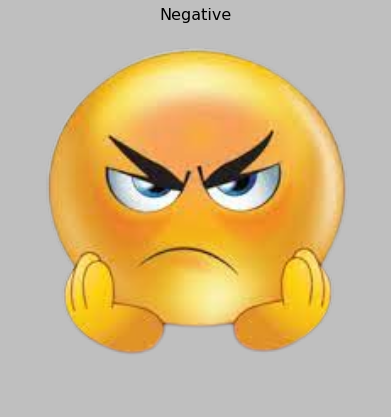

In [ ]:
show_emoji(most_sent)

## Voice Input

It can detect your voice and analyze the sentiment of your told sentence.

Using SpeechRecoginition
and ffmpeg-python

In [ ]:
!pip install ffmpeg-python
!pip install SpeechRecognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 42.4 MB/s eta 0:00:00


### used JavaScript code to get voice input using browser, because Google Colab cannot get input from device directly.



```
https://colab.research.google.com/drive/1L1dTNjMvvIRh6dlxABmgRqcWFw7a62Jo
```



In [ ]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

### Input your voice

In [ ]:
audio, sr = get_audio()

In [ ]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

In [ ]:
import speech_recognition as sr

# create a recognizer object
r = sr.Recognizer()

# use the audio file as the audio source
with sr.AudioFile("recording.wav") as source:
    audio = r.record(source)  # read the entire audio file

# recognize speech using Google Speech Recognition
try:
    text = r.recognize_google(audio)
    print("You said: " + text)
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))


You said: what the hell are you doing man you're really great


In [ ]:
# Code to take input by user and show its sentiment
df5 = pd.DataFrame({'text': [text]})

df5['text'] = df5['text'].apply(lambda x: data_processing(x))
df5['text'] = df5['text'].apply(lambda x: stemming(x))

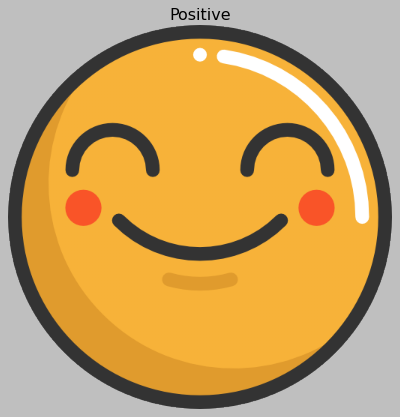

In [ ]:
# Transform the tweets into numerical representations
text_vectors1 = vect.transform(df5['text'].values)

# load the saved model
myModel = joblib.load('model.pkl')

# Feed the numerical representations into the trained model to make predictions
predictions1 = myModel.predict(text_vectors1)

# Display sentiment
show_emoji(predictions1)

## Just to check accuracy using another dataset.

In [ ]:
!cp "/content/gdrive/MyDrive/new1.zip" "/content/new1.zip"
!unzip "/content/new1.zip" -d "/content/"

Archive:  /content/new1.zip
  inflating: /content/Sentences_50Agree.txt  
  inflating: /content/Sentences_66Agree.txt  
  inflating: /content/Sentences_75Agree.txt  
  inflating: /content/Sentences_AllAgree.txt  


In [ ]:
!ls


angry.png    new1.zip		     testdata.manual.2009.06.14.csv
archive.zip  recording.wav	     train.csv
emoji.zip    sample_data	     training.1600000.processed.noemoticon.csv
gdrive	     Sentences_50Agree.txt   Twitter1.zip
happy.png    Sentences_66Agree.txt   twitter_training1.csv
Login.csv    Sentences_75Agree.txt   twitter_validation1.csv
model.pkl    Sentences_AllAgree.txt  vect.pkl
neutral.png  test.csv


In [ ]:
val_df = pd.read_csv("train.csv", encoding='ISO-8859-1')

In [ ]:
val_df = val_df[val_df['sentiment'] != 'Irrelevant']
val_df.isnull().sum()
val_df = val_df[pd.notnull(val_df['text'])]
#df3= val_df.drop(['id', 'source'], axis=1)
df3 = val_df.drop_duplicates('text')

In [ ]:
df3['text'] = df3['text'].apply(lambda x: data_processing(x))
df3['text'] = df3['text'].apply(lambda x: stemming(x))
#vect3 = CountVectorizer(ngram_range=(1,2)).fit(df3['text'])
vect3 = joblib.load("vect.pkl")

In [ ]:
X1 = df3['text']
Y1 = df3['sentiment']
X1 = vect3.transform(X1)

In [ ]:
model_pred1 = myModel.predict(x_test)
model_acc1 = accuracy_score(model_pred1, y_test)
print("Test accuracy: {:.2f}%".format(model_acc1*100))

Test accuracy: 94.40%


## Analysis of any dataset.

In [ ]:
def datasetAnalysis(df):
    # Preprocessing 
    df = df.drop_duplicates('text')
    df = df['text'].apply(lambda x: data_processing(x))
    df = df.apply(lambda x: stemming(x))

    # Vectorize the text data
    vect = joblib.load("vect.pkl")
    transformed_text = vect.transform(df)

    # Load the model and predict sentiment
    myModel = joblib.load('model.pkl') #loading the model
    predictions = myModel.predict(transformed_text)
    
    return predictions

In [ ]:
# Load the data and preprocess it
my_df = pd.read_csv("twitter_validation1.csv", encoding='ISO-8859-1')
predictions = datasetAnalysis(my_df)
# Convert predictions to a Pandas Series
sentiments = pd.Series(predictions)

In [ ]:
predictions

array(['Negative', 'Neutral', 'Negative', 'Negative', 'Neutral',
       'Negative', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Positive', 'Negative', 'Positive', 'Negative',
       'Negative', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral',
       'Negative', 'Neutral', 'Positive', 'Negative', 'Positive',
       'Positive', 'Negative', 'Positive', 'Negative', 'Neutral',
       'Neutral', 'Positive', 'Positive', 'Neutral', 'Positive',
       'Neutral', 'Neutral', 'Neutral', 'Positive', 'Neutral', 'Negative',
       'Negative', 'Negative', 'Neutral', 'Positive', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Negative', 'Positive', 'Negative', 'Positive',
       'Positive', 'Neutral', 'Negative', 'Neutral', 'Negative',
       'Neutral', 'Neutral', 'Negative', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Negative', 'Po

Text(0.5, 1.0, 'Distribution of Sentiments of given dataset')

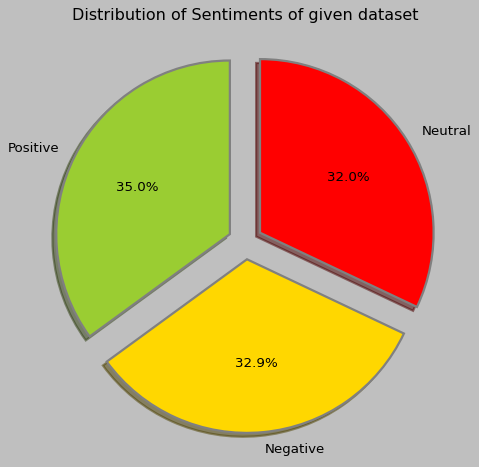

In [ ]:
fig = plt.figure(figsize=(7,7))
colors=("yellowgreen","gold","red")
wp={'linewidth':2, 'edgecolor':'grey'}
tags = sentiments.value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie',autopct='%1.1f%%', shadow=True, colors = colors, startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of Sentiments of given dataset')